In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# To ignore future warnings of plot
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
# For Stopwords
import nltk
from nltk.corpus import stopwords
# For parsing
import re
# For data analyzing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
# For data modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from keras.layers import Embedding
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

## Importing Data

In [2]:
# Reading and saving the data set into data object
data = pd.read_csv("/kaggle/input/sentiment-analysis/sentiment_analysis.csv", encoding = "utf-16")
# Let's see what is inside the data
data.head()

,Görüş,Durum
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz
1,hizli teslimat tesekkürler,Tarafsız
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz


## Preprocessing

In [3]:
data = data.rename({'Görüş': 'Review'}, axis=1)
data = data.rename({'Durum': 'Status'}, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11429 entries, 0 to 11428
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  11426 non-null  object
 1   Status  11429 non-null  object
dtypes: object(2)
memory usage: 178.7+ KB


### 1. Removing null values

In [4]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11426 entries, 0 to 11428
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  11426 non-null  object
 1   Status  11426 non-null  object
dtypes: object(2)
memory usage: 267.8+ KB


<AxesSubplot:xlabel='Status', ylabel='count'>

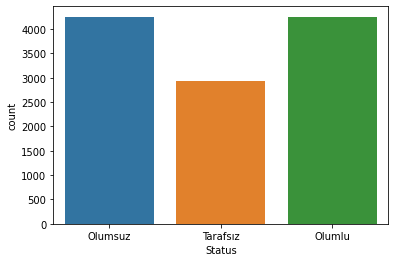

In [5]:
sns.countplot(data["Status"]) 

### **2. Replacing Turkish characters with English characters**

#### **Replacement Function**

In [6]:
def replaceLetters(sentence):
    # Turning sentence into list of words
    listOfLetters = list(sentence)
    # Checking for every word in the sentence
    for i in range(0, len(listOfLetters)):
        if listOfLetters[i] == "ü":
            listOfLetters[i] = "u"
        elif listOfLetters[i] == "Ü":
            listOfLetters[i] = "U"
        elif listOfLetters[i] == "ö":
            listOfLetters[i] = "o"
        elif listOfLetters[i] == "Ö":
            listOfLetters[i] = "O"
        elif listOfLetters[i] == "İ":
            listOfLetters[i] = "I"
        elif listOfLetters[i] == "ç":
            listOfLetters[i] = "c"
        elif listOfLetters[i] == "Ç":
            listOfLetters[i] = "C"
        elif listOfLetters[i] == "ğ":
            listOfLetters[i] = "g"
        elif listOfLetters[i] == "Ğ":
            listOfLetters[i] = "G"
        elif listOfLetters[i] == "ş":
            listOfLetters[i] = "s"
        elif listOfLetters[i] == "Ş":
            listOfLetters[i] = "S"
        elif listOfLetters[i] == "ı":
            listOfLetters[i] = "i"
        
    # Turning list of letters into one string
    sentence0 = ''.join(listOfLetters)
    
    # Change every symbol except letters into space
    sentence1 = re.sub("[^a-zA-Z]", " ", sentence0)
    sentence2 = sentence1.lower()
    
    # Tokenizing the sentence1 after lowercasing the letters inside the sentence
    sentence2 = nltk.word_tokenize(sentence2)    
    # Removing stopwords from sentences
    sentence2 = [word for word in sentence2 if not word in set(stopwords.words("turkish"))]

    sentence3 = " ".join(sentence2)
    
    return sentence3

#### a. Normal data

In [7]:
normal_data = data['Review']

print(normal_data[251])

ürünü hiç ama hiç beğenmedim kimse tavsiye etmiyorum. Ürünün içi plastik
dolu. paslanmaz çelik yazıyor tamam da filtre plastik, vida plastik,
içindeki rezidansın başlığı da plastik kesinlikle sağlıklı bir ürün
değil arkadaşlar. bilseydim almazdım. içinde plastik parçalar olmayan
çelik ya da cam kettle'lar kullanılmalı.


#### b. Replaced Version (Also removed stopwords)

In [8]:
replaced_data = []

X = data['Review'].values
for i in range(len(X)):
    X_ = replaceLetters(X[i])
    replaced_data.append(X_)

print(replaced_data[251])

urunu hic hic begenmedim kimse tavsiye etmiyorum urunun ici plastik dolu paslanmaz celik yaziyor tamam filtre plastik vida plastik icindeki rezidansin basligi plastik kesinlikle saglikli bir urun degil arkadaslar bilseydim almazdim icinde plastik parcalar olmayan celik cam kettle lar kullanilmali


## **Data Analyzing**

### **1. Most Frequently Used Words**

In [9]:
cv = CountVectorizer(max_features = 1000, stop_words = stopwords.words("turkish"))

space_matrix = cv.fit_transform(replaced_data).toarray() # x

print("Most frequently used {} words {}".format(10, cv.get_feature_names_out()[0:10]))



Most frequently used 2000 words ['ac' 'acayip' 'acidan' ... 'zeminde' 'zor' 'zorunda']


### **2. Word Cloud**

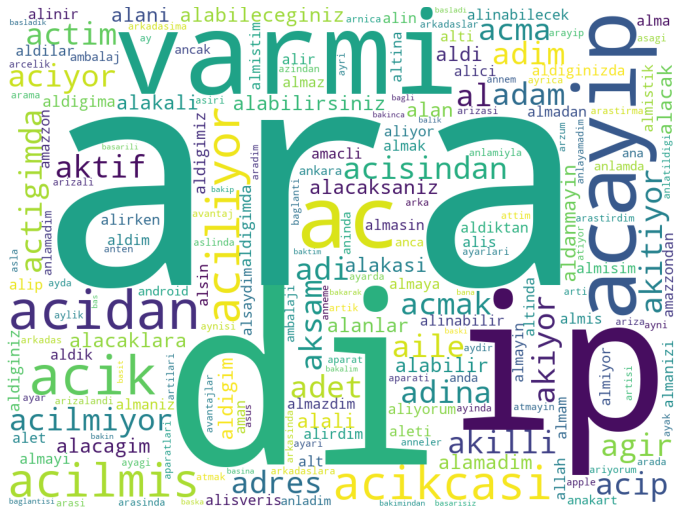

In [10]:
most_frequently_used_words = cv.get_feature_names_out()

plt.subplots(figsize=(12,12))
wordcloud=WordCloud(background_color="white",width=1024,height=768).generate(" ".join(list(most_frequently_used_words)))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## **Machine Learning Models**

In [42]:
vectorizer = TfidfVectorizer()
#X = space_matrix
X = vectorizer.fit_transform(replaced_data)
y = data.iloc[:,1].values

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 1)
#x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 0)

# Will be used to test models
def testModels(model):
    reviews = [
        "Ürün güzel ancak içinde süzgeci olduğunda kapak tam olarak oturmuyor",
        "Güzel bir ürün işime yaradı.",
        "aldığınıza pişman olursunuz tavsiye etmiyorum.",
    ]
    
    for review in reviews:
        # Replace Turkish characters with English and remove stopwords, etc. 
        review = replaceLetters(review)
        # Use vectorizer
        reviewVec = vectorizer.transform([review])
        # Predict     
        prediction = model.predict(reviewVec)
        
        print(f'Review: {review} | Prediction: {prediction} ')

### **1. Multinomial Naïve Bayes**

In [43]:
mnb = MultinomialNB()

mnb.fit(x_train,y_train)

y_pred_mnb = mnb.predict(x_test)

print("MultinomialNB Accuracy  : ", accuracy_score(y_pred_mnb, y_test))
print("MultinomialNB Precision : ", precision_score(y_test, y_pred_mnb, average='weighted'))
print("MultinomialNB Recall    : ", recall_score(y_test, y_pred_mnb, average='weighted'))
print("MultinomialNB F1        : ", f1_score(y_test, y_pred_mnb, average='weighted'))
print("\n")
testModels(mnb)

MultinomialNB Accuracy  :  0.7147024504084014
MultinomialNB Precision :  0.7140080170487434
MultinomialNB Recall    :  0.7147024504084014
MultinomialNB F1        :  0.662260163803594


Review: urun guzel ancak icinde suzgeci oldugunda kapak tam olarak oturmuyor | Prediction: ['Olumlu'] 
Review: guzel bir urun isime yaradi | Prediction: ['Olumlu'] 
Review: aldiginiza pisman olursunuz tavsiye etmiyorum | Prediction: ['Olumsuz'] 


#### **a. Using SMOTE to Oversample Neutral Data** 

In [13]:
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smote = SMOTE(sampling_strategy='minority',random_state=42, k_neighbors=2)
#smote = SMOTE(sampling_strategy='minority')

# Fit and transform the training data
x_train_oversampled, y_train_oversampled = smote.fit_resample(x_train, y_train)

mnb.fit(x_train_oversampled, y_train_oversampled)

y_pred_mnb = mnb.predict(x_test)

print("MultinomialNB_SMOTE Accuracy  : ", accuracy_score(y_pred_mnb, y_test))
print("MultinomialNB_SMOTE Precision : ", precision_score(y_test, y_pred_mnb, average='weighted'))
print("MultinomialNB_SMOTE Recall    : ", recall_score(y_test, y_pred_mnb, average='weighted'))
print("MultinomialNB_SMOTE F1        : ", f1_score(y_test, y_pred_mnb, average='weighted'))
print("\n")
testModels(mnb)

MultinomialNB_SMOTE Accuracy  :  0.7222870478413069
MultinomialNB_SMOTE Precision :  0.7156001171477675
MultinomialNB_SMOTE Recall    :  0.7222870478413069
MultinomialNB_SMOTE F1        :  0.7180479732535984


Review: urun guzel ancak icinde suzgeci oldugunda kapak tam olarak oturmuyor | Prediction: ['Tarafsız'] 
Review: guzel bir urun isime yaradi | Prediction: ['Olumlu'] 
Review: aldiginiza pisman olursunuz tavsiye etmiyorum | Prediction: ['Olumsuz'] 


#### **b. Using RandomUnderSampler to Undersample Neutral Data** 

In [44]:
from imblearn.under_sampling import RandomUnderSampler

# Create an instance of RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority',random_state=42)

# Fit and transform the training data
x_train_undersampled, y_train_undersampled = rus.fit_resample(x_train, y_train)

y_pred_mnb = mnb.predict(x_test)

print("MultinomialNB_RU Accuracy  : ", accuracy_score(y_pred_mnb, y_test))
print("MultinomialNB_RU Precision : ", precision_score(y_test, y_pred_mnb))
print("MultinomialNB_RU Recall    : ", recall_score(y_test, y_pred_mnb))
print("MultinomialNB_RU F1        : ", f1_score(y_test, y_pred_mnb))
print("\n")
testModels(mnb)

MultinomialNB_RU Accuracy  :  0.7147024504084014
MultinomialNB_RU Precision :  0.7140080170487434
MultinomialNB_RU Recall    :  0.7147024504084014
MultinomialNB_RU F1        :  0.662260163803594


Review: urun guzel ancak icinde suzgeci oldugunda kapak tam olarak oturmuyor | Prediction: ['Olumlu'] 
Review: guzel bir urun isime yaradi | Prediction: ['Olumlu'] 
Review: aldiginiza pisman olursunuz tavsiye etmiyorum | Prediction: ['Olumsuz'] 


### **2. Multinomial Logistic Regression**

In [15]:
logr = LogisticRegression(multi_class='multinomial', max_iter=11500)

logr.fit(x_train, y_train)

y_pred_logr = logr.predict(x_test)

print("Multinomial Logistic Regression Accuracy  : ", accuracy_score(y_pred_logr, y_test))
print("Multinomial Logistic Regression Precision : ", precision_score(y_test, y_pred_logr, average='weighted'))
print("Multinomial Logistic Regression Recall    : ", recall_score(y_test, y_pred_logr, average='weighted'))
print("Multinomial Logistic Regression F1        : ", f1_score(y_test, y_pred_logr, average='weighted'))
print("\n")
testModels(mnb)

Multinomial Logistic Regression Accuracy  :  0.7158693115519253
Multinomial Logistic Regression Precision :  0.7024994468316285
Multinomial Logistic Regression Recall    :  0.7158693115519253
Multinomial Logistic Regression F1        :  0.7032094322079269


Review: urun guzel ancak icinde suzgeci oldugunda kapak tam olarak oturmuyor | Prediction: ['Tarafsız'] 
Review: guzel bir urun isime yaradi | Prediction: ['Olumlu'] 
Review: aldiginiza pisman olursunuz tavsiye etmiyorum | Prediction: ['Olumsuz'] 


### **3. Support Vector Machine**

In [16]:
svc = SVC()
svc.fit(x_train, y_train)

y_pred_svc = svc.predict(x_test)

print("SVC Accuracy  : ", accuracy_score(y_pred_svc, y_test))
print("SVC Precision : ", precision_score(y_test, y_pred_svc, average='weighted'))
print("SVC Recall    : ", recall_score(y_test, y_pred_svc, average='weighted'))
print("SVC F1        : ", f1_score(y_test, y_pred_svc, average='weighted'))
print("\n")
testModels(mnb)

SVC Accuracy  :  0.7292882147024504
SVC Precision :  0.7193960566233893
SVC Recall    :  0.7292882147024504
SVC F1        :  0.7174452278476063


Review: urun guzel ancak icinde suzgeci oldugunda kapak tam olarak oturmuyor | Prediction: ['Tarafsız'] 
Review: guzel bir urun isime yaradi | Prediction: ['Olumlu'] 
Review: aldiginiza pisman olursunuz tavsiye etmiyorum | Prediction: ['Olumsuz'] 
